In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

**Data Pre-processing**

In [2]:
df=pd.read_csv('/content/Ev Sales .csv')


In [3]:
df

,YEAR,2 W,3 W,4 W,BUS,TOTAL
0,Apr-17,96,4748,198,0,5042
1,May-17,91,6720,215,2,7028
2,Jun-17,137,7178,149,1,7465
3,Jul-17,116,8775,120,0,9011
4,Aug-17,99,8905,137,0,9141
...,...,...,...,...,...,...
69,Jan-23,64649,34308,3490,98,102545
70,Feb-23,66033,35995,4850,99,106977
71,Mar-23,86194,45225,8852,89,140360
72,Apr-23,66755,38016,6193,84,111048


In [4]:
df.rename(columns={'YEAR':'Year','2 W':'2_Wheeler','3 W':'3_Wheeler','4 W':'4_Wheeler','BUS':'Bus','TOTAL':'Total'},inplace=True)


In [5]:
df.columns

Index(['Year', '2_Wheeler', '3_Wheeler', '4_Wheeler', 'Bus', 'Total'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       74 non-null     object
 1   2_Wheeler  74 non-null     int64 
 2   3_Wheeler  74 non-null     int64 
 3   4_Wheeler  74 non-null     int64 
 4   Bus        74 non-null     int64 
 5   Total      74 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 3.6+ KB


In [7]:
df.describe()

,2_Wheeler,3_Wheeler,4_Wheeler,Bus,Total
count,74.000000,74.000000,74.000000,74.000000,74.000000
mean,16938.729730,14851.351351,1272.567568,82.310811,33144.959459
std,25846.636971,11002.517635,1841.195763,79.696672,38251.453387
min,85.000000,668.000000,3.000000,0.000000,958.000000
25%,1304.250000,7782.250000,187.750000,11.250000,9147.000000
50%,3014.500000,10619.500000,317.500000,74.500000,14526.000000
75%,23599.000000,18641.750000,1545.000000,113.500000,43902.750000
max,105154.000000,45225.000000,8852.000000,331.000000,157788.000000


In [8]:
df.to_csv('EvSales_updated.csv', index=False)


In [9]:
df['Year'] = pd.to_datetime(df['Year'], format='%b-%y')

# Extract the year only
df['YearOnly'] = df['Year'].dt.year

# Group by year and sum the sales for each vehicle type
yearly_sales = df.groupby('YearOnly')[['2_Wheeler', '3_Wheeler', '4_Wheeler', 'Bus']].sum().reset_index()


**EDA**

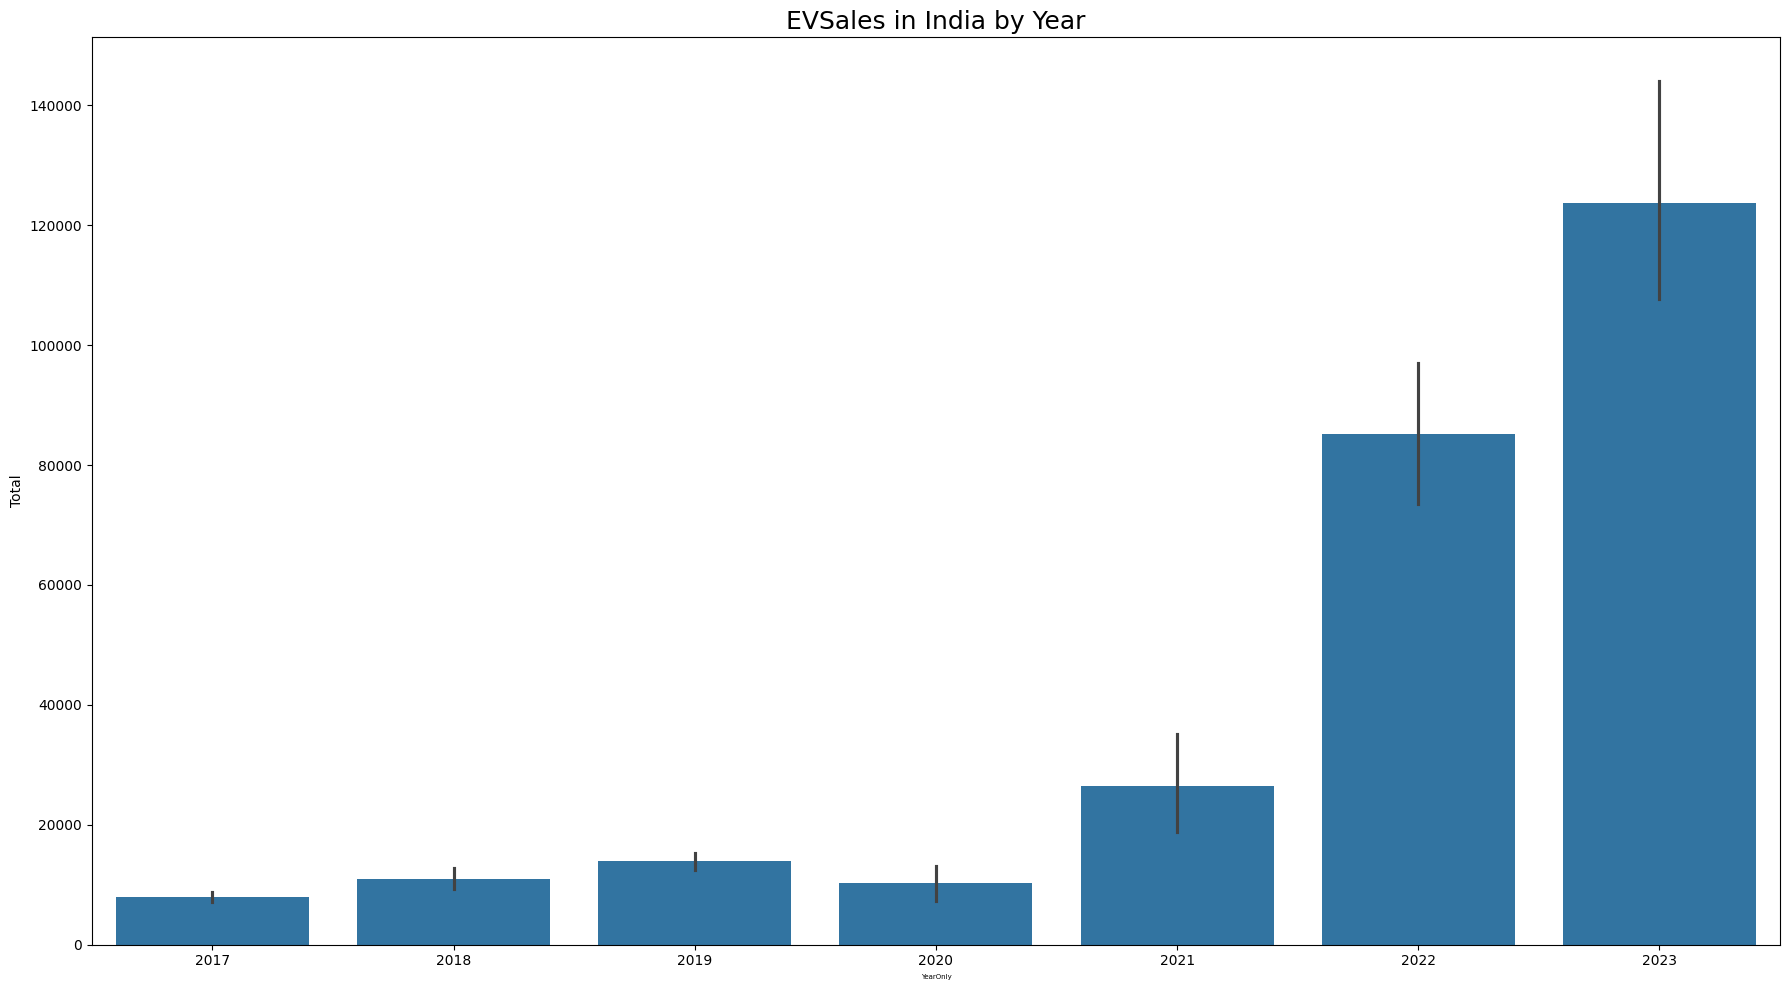

In [10]:
plt.figure(figsize=(18,10),facecolor='White')
sns.barplot(data=df,x='YearOnly',y='Total')
plt.title("EVSales in India by Year", fontsize=18)
plt.xlabel("YearOnly",fontsize=5)
plt.ylabel("Total",fontsize=10)
plt.tight_layout()
plt.show()

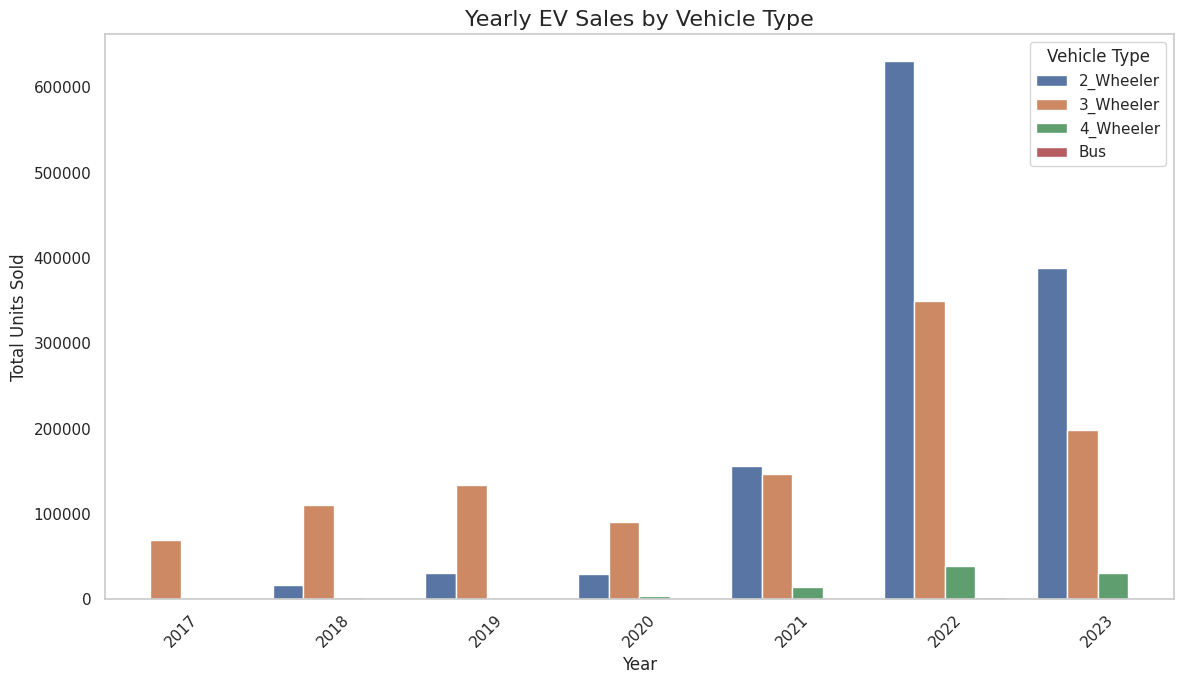

In [11]:
yearly_sales_melted = yearly_sales.melt(id_vars='YearOnly', var_name='Vehicle Type', value_name='Units Sold')

# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=yearly_sales_melted, x='YearOnly', y='Units Sold', hue='Vehicle Type')
plt.title('Yearly EV Sales by Vehicle Type', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Units Sold', fontsize=12)
plt.legend(title='Vehicle Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

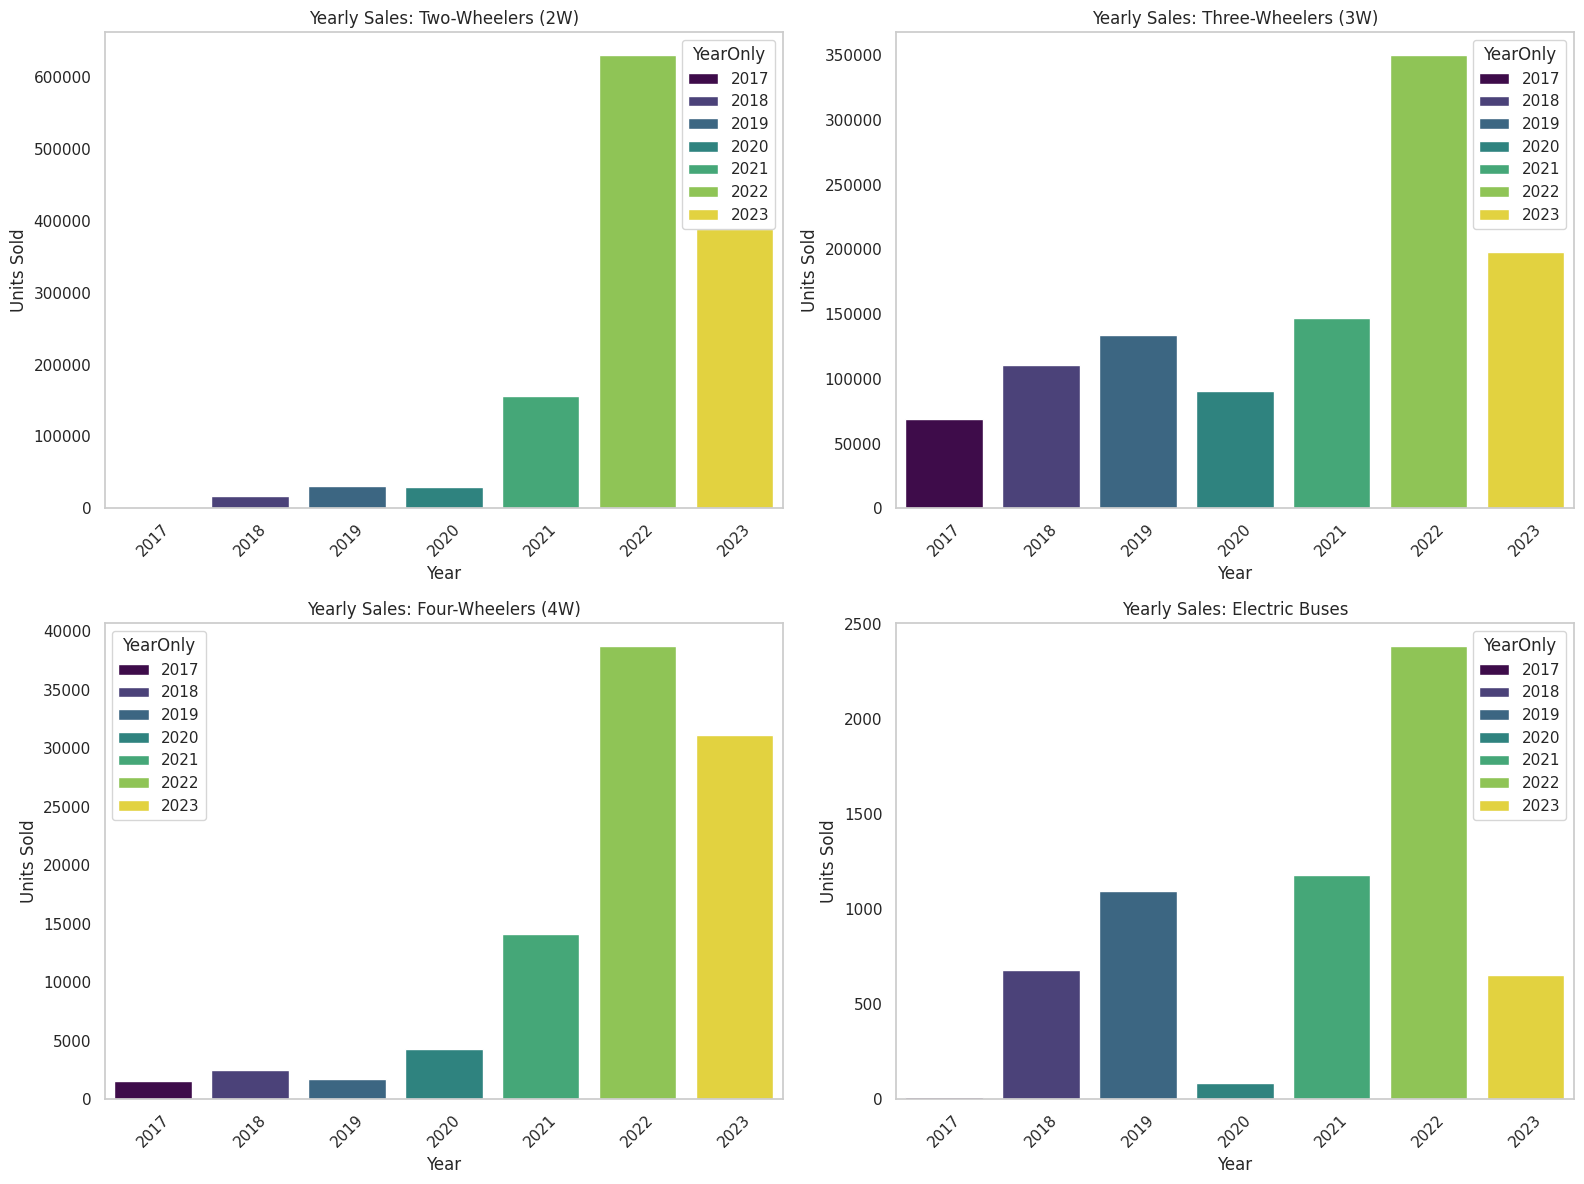

In [12]:
vehicle_types = ['2_Wheeler', '3_Wheeler', '4_Wheeler', 'Bus']
titles = ['Two-Wheelers (2W)', 'Three-Wheelers (3W)', 'Four-Wheelers (4W)', 'Electric Buses']

# Plot each vehicle type in a separate subplot
plt.figure(figsize=(16, 12))

for i, vt in enumerate(vehicle_types):
    plt.subplot(2, 2, i + 1)
    sns.barplot(data=yearly_sales, x='YearOnly', y=vt, palette='viridis',hue='YearOnly')
    plt.title(f'Yearly Sales: {titles[i]}')
    plt.xlabel('Year')
    plt.ylabel('Units Sold')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Model Creation**

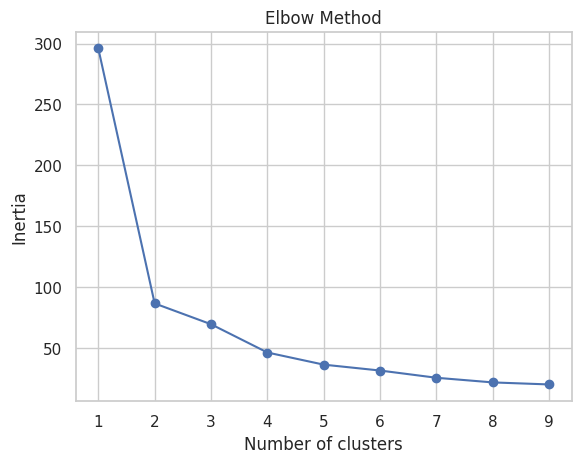

In [13]:
from sklearn.preprocessing import StandardScaler

pivot = df[['2_Wheeler', '3_Wheeler', '4_Wheeler', 'Bus']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot)
# doing k mean klustering to get more insights

from sklearn.cluster import KMeans


inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

We can see that at 2 its taking a sharp turn hence the k=2.

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pivot['Cluster'] = clusters
# getting the mean for every custer
cluster_profiles = pivot.groupby('Cluster').mean()
print(cluster_profiles)

            2_Wheeler     3_Wheeler    4_Wheeler         Bus
Cluster                                                     
0         3702.392857   9403.464286   386.785714   50.571429
1        58118.444444  31800.333333  4028.333333  181.055556


In [15]:
cluster_profiles = pivot.groupby('Cluster').mean()
print(cluster_profiles)

            2_Wheeler     3_Wheeler    4_Wheeler         Bus
Cluster                                                     
0         3702.392857   9403.464286   386.785714   50.571429
1        58118.444444  31800.333333  4028.333333  181.055556


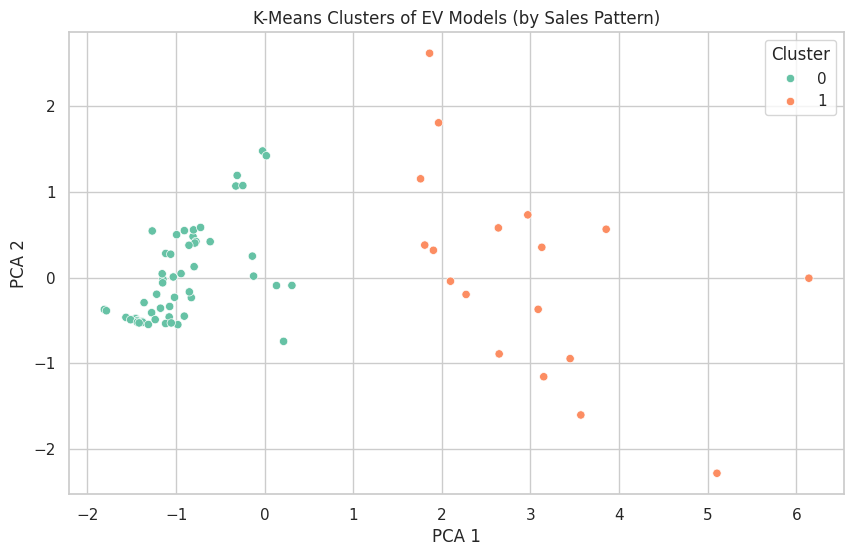

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=pivot['Cluster'], palette='Set2')
plt.title("K-Means Clusters of EV Models (by Sales Pattern)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [17]:
pivot.groupby('Cluster').mean()


,2_Wheeler,3_Wheeler,4_Wheeler,Bus
Cluster,,,,
0,3702.392857,9403.464286,386.785714,50.571429
1,58118.444444,31800.333333,4028.333333,181.055556


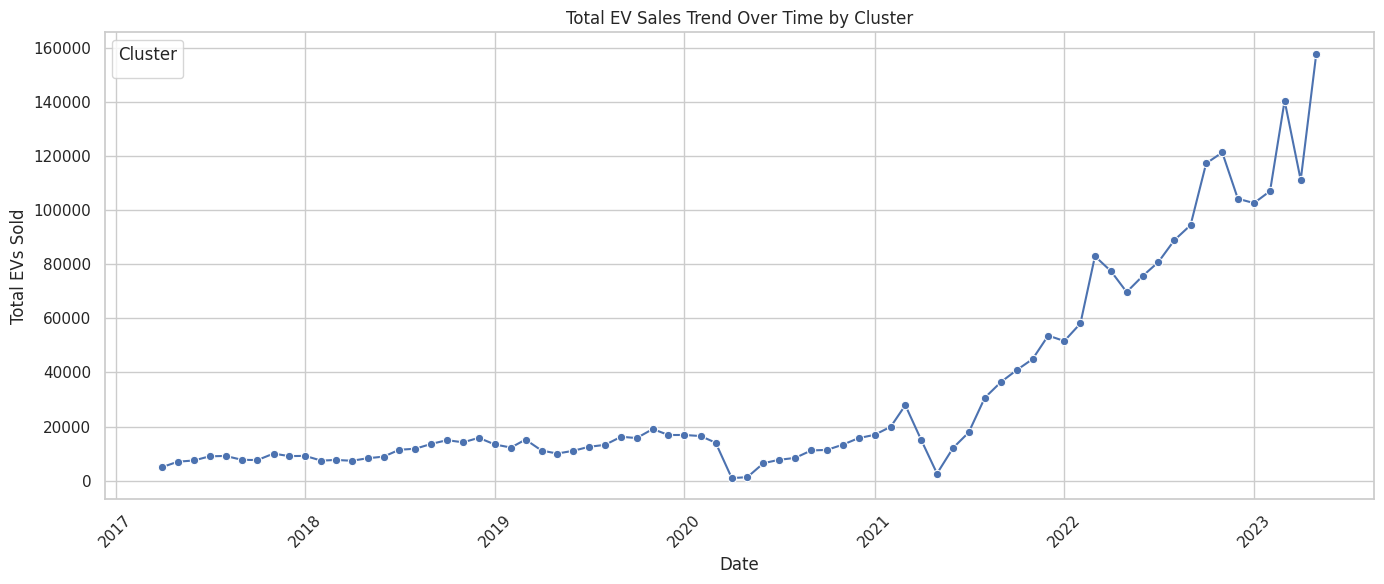

In [18]:
#k means clustering on vechicle sales
sns.set(style="whitegrid")

# Sort by date
df_sorted = df.sort_values('Year')

# Plot total EV sales per month, colored by cluster
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_sorted, x='Year', y=df_sorted[['2_Wheeler', '3_Wheeler', '4_Wheeler', 'Bus']].sum(axis=1),
             palette='Set2', marker='o')

plt.title('Total EV Sales Trend Over Time by Cluster')
plt.xlabel('Date')
plt.ylabel('Total EVs Sold')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

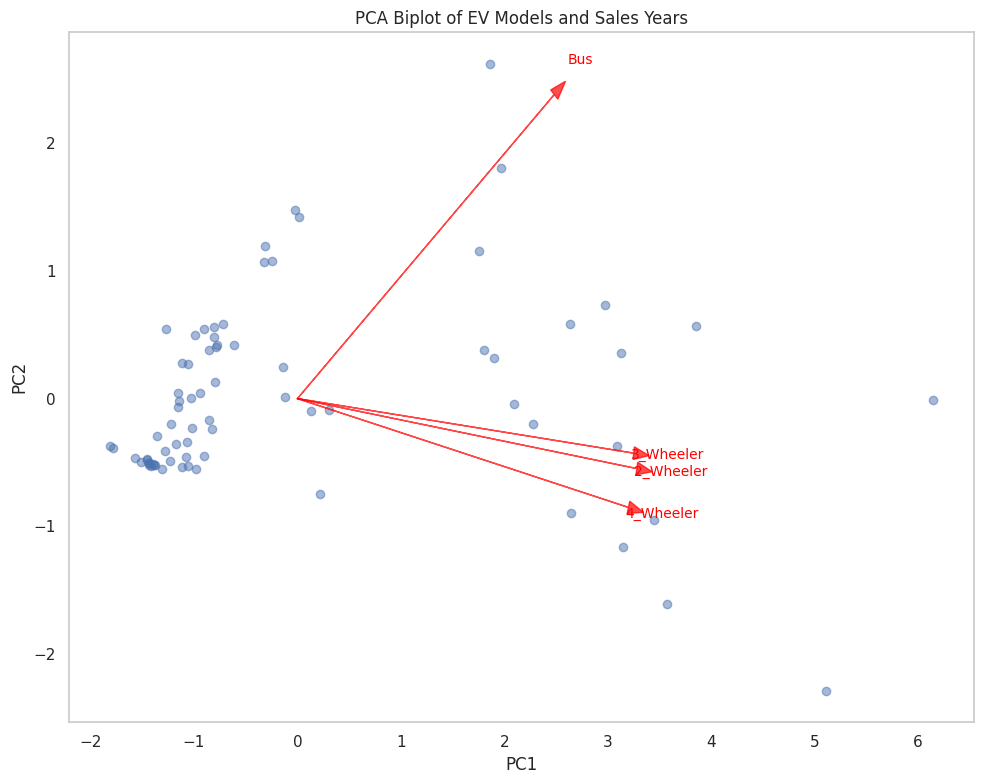

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))

# Plot data points
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

features = pivot.columns
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0,
              pca.components_[0, i] * max(pca_result[:, 0]),
              pca.components_[1, i] * max(pca_result[:, 1]),
              color='red', alpha=0.7, head_width=0.1)
    plt.text(pca.components_[0, i] * max(pca_result[:, 0]) * 1.1,
             pca.components_[1, i] * max(pca_result[:, 1]) * 1.1,
             pivot.columns[i], color='red', ha='center', fontsize=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot of EV Models and Sales Years")
plt.grid()
plt.tight_layout()
plt.show()



**Loading second dataset**

**Data Pre-processsing**

In [20]:
df=pd.read_csv('/content/Ev_Demographic.csv')

In [21]:
df

,State Name,Two Wheeler,Three Wheeler,Four Wheeler,Goods Vehicles,Public Service Vehicle,Grand Total
0,Andaman and Nicobar Island,1,30.0,81,NaN,40.0,152
1,Arunachal Pradesh,14,NaN,5,NaN,NaN,19
2,Assam,721,47041.0,161,7.0,15.0,47945
3,Bihar,5003,59079.0,114,11.0,26.0,64233
4,Chandigarh,298,1410.0,182,NaN,40.0,1930
5,Chhattisgarh,6424,5341.0,117,1077.0,1.0,12960
6,Delhi,14730,112831.0,3051,49.0,39.0,130700
7,Goa,1314,28.0,289,13.0,36.0,1680
8,Gujarat,13662,1869.0,1309,28.0,278.0,17146
9,Haryana,7777,18595.0,186,122.0,8.0,26688


In [22]:
df.describe()

,Two Wheeler,Three Wheeler,Four Wheeler,Goods Vehicles,Public Service Vehicle,Grand Total
count,33.000000,29.000000,33.000000,29.000000,25.000000,33.000000
mean,17123.757576,44633.517241,1596.060606,209.379310,163.120000,58250.787879
std,49890.139178,126709.405409,4732.596387,621.003129,429.671611,170599.239494
min,1.000000,1.000000,2.000000,1.000000,1.000000,17.000000
25%,69.000000,167.000000,14.000000,3.000000,10.000000,1519.000000
50%,2540.000000,4470.000000,139.000000,21.000000,36.000000,12114.000000
75%,10329.000000,22096.000000,709.000000,43.000000,44.000000,47945.000000
max,282542.000000,647186.000000,26335.000000,3036.000000,2039.000000,961138.000000


In [23]:
#renaming columns names
df.rename(columns={'State Name':'State_Name','Two Wheeler':'Two_Wheeler','Three Wheeler':'Three_Wheeler','Four Wheeler':'Four_Wheeler','Goods Vehicles':'Goods_Vehicles','Public Service Vehicle':'Public_Service_Vehicle','Grand Total':'Grand_Total'},inplace=True)




In [24]:
# checking null values
df.isnull().sum()

,0
State_Name,0
Two_Wheeler,0
Three_Wheeler,4
Four_Wheeler,0
Goods_Vehicles,4
Public_Service_Vehicle,8
Grand_Total,0


In [25]:
# imputing Null values with Mode

print(df.Three_Wheeler.mode())
print(df.Goods_Vehicles.mode())
print(df.Public_Service_Vehicle.mode())

0          1.0
1          6.0
2         28.0
3         30.0
4         32.0
5         36.0
6         43.0
7        167.0
8        443.0
9       1410.0
10      1808.0
11      1869.0
12      2115.0
13      2878.0
14      4470.0
15      5341.0
16      6155.0
17      7510.0
18      8986.0
19     16478.0
20     18595.0
21     22096.0
22     29631.0
23     40948.0
24     47041.0
25     59079.0
26    112831.0
27    257159.0
28    647186.0
Name: Three_Wheeler, dtype: float64
0    1.0
Name: Goods_Vehicles, dtype: float64
0    1.0
Name: Public_Service_Vehicle, dtype: float64


In [26]:
df.columns=df.columns.str.strip()
df.loc[df['Three_Wheeler'].isnull()]
df.loc[df['Goods_Vehicles'].isnull()]
df.loc[df['Public_Service_Vehicle'].isnull()]



,State_Name,Two_Wheeler,Three_Wheeler,Four_Wheeler,Goods_Vehicles,Public_Service_Vehicle,Grand_Total
1,Arunachal Pradesh,14,NaN,5,NaN,NaN,19
15,Ladakh,12,NaN,5484,NaN,NaN,5496
17,Manipur,86,443.0,9,1.0,NaN,539
18,Meghalaya,16,6.0,3,3.0,NaN,28
20,Nagaland,44,NaN,121,3.0,NaN,168
21,Odisha,10329,1808.0,75,21.0,NaN,12233
25,Sikkim,1,NaN,2414,1.0,NaN,2416
27,Tripura,67,7510.0,14,1.0,NaN,7592


In [27]:
df.loc[df['Three_Wheeler'].isnull()==True,'Three_Wheeler']='Yes'
df.loc[df['Goods_Vehicles'].isnull()==True,'Goods_Vehicles']='Yes'
df.loc[df['Public_Service_Vehicle'].isnull()==True,'Public_Service_Vehicle']='Yes'


In [28]:
#null values imputed
df.loc[df['Three_Wheeler'].isnull()]
df.loc[df['Goods_Vehicles'].isnull()]
df.loc[df['Public_Service_Vehicle'].isnull()]


,State_Name,Two_Wheeler,Three_Wheeler,Four_Wheeler,Goods_Vehicles,Public_Service_Vehicle,Grand_Total


In [29]:
df.duplicated().sum()


np.int64(0)

In [36]:
df = df[df['State_Name'] != 'Grand Total']

In [63]:
df

,State_Name,Two_Wheeler,Three_Wheeler,Four_Wheeler,Goods_Vehicles,Public_Service_Vehicle,Grand_Total
0,Andaman and Nicobar Island,1,30.0,81,Yes,40.0,152
1,Arunachal Pradesh,14,NaN,5,Yes,Yes,19
2,Assam,721,47041.0,161,7.0,15.0,47945
3,Bihar,5003,59079.0,114,11.0,26.0,64233
4,Chandigarh,298,1410.0,182,Yes,40.0,1930
5,Chhattisgarh,6424,5341.0,117,1077.0,1.0,12960
6,Delhi,14730,112831.0,3051,49.0,39.0,130700
7,Goa,1314,28.0,289,13.0,36.0,1680
8,Gujarat,13662,1869.0,1309,28.0,278.0,17146
9,Haryana,7777,18595.0,186,122.0,8.0,26688


**EDA**

Ev sales according to vehicle types and states

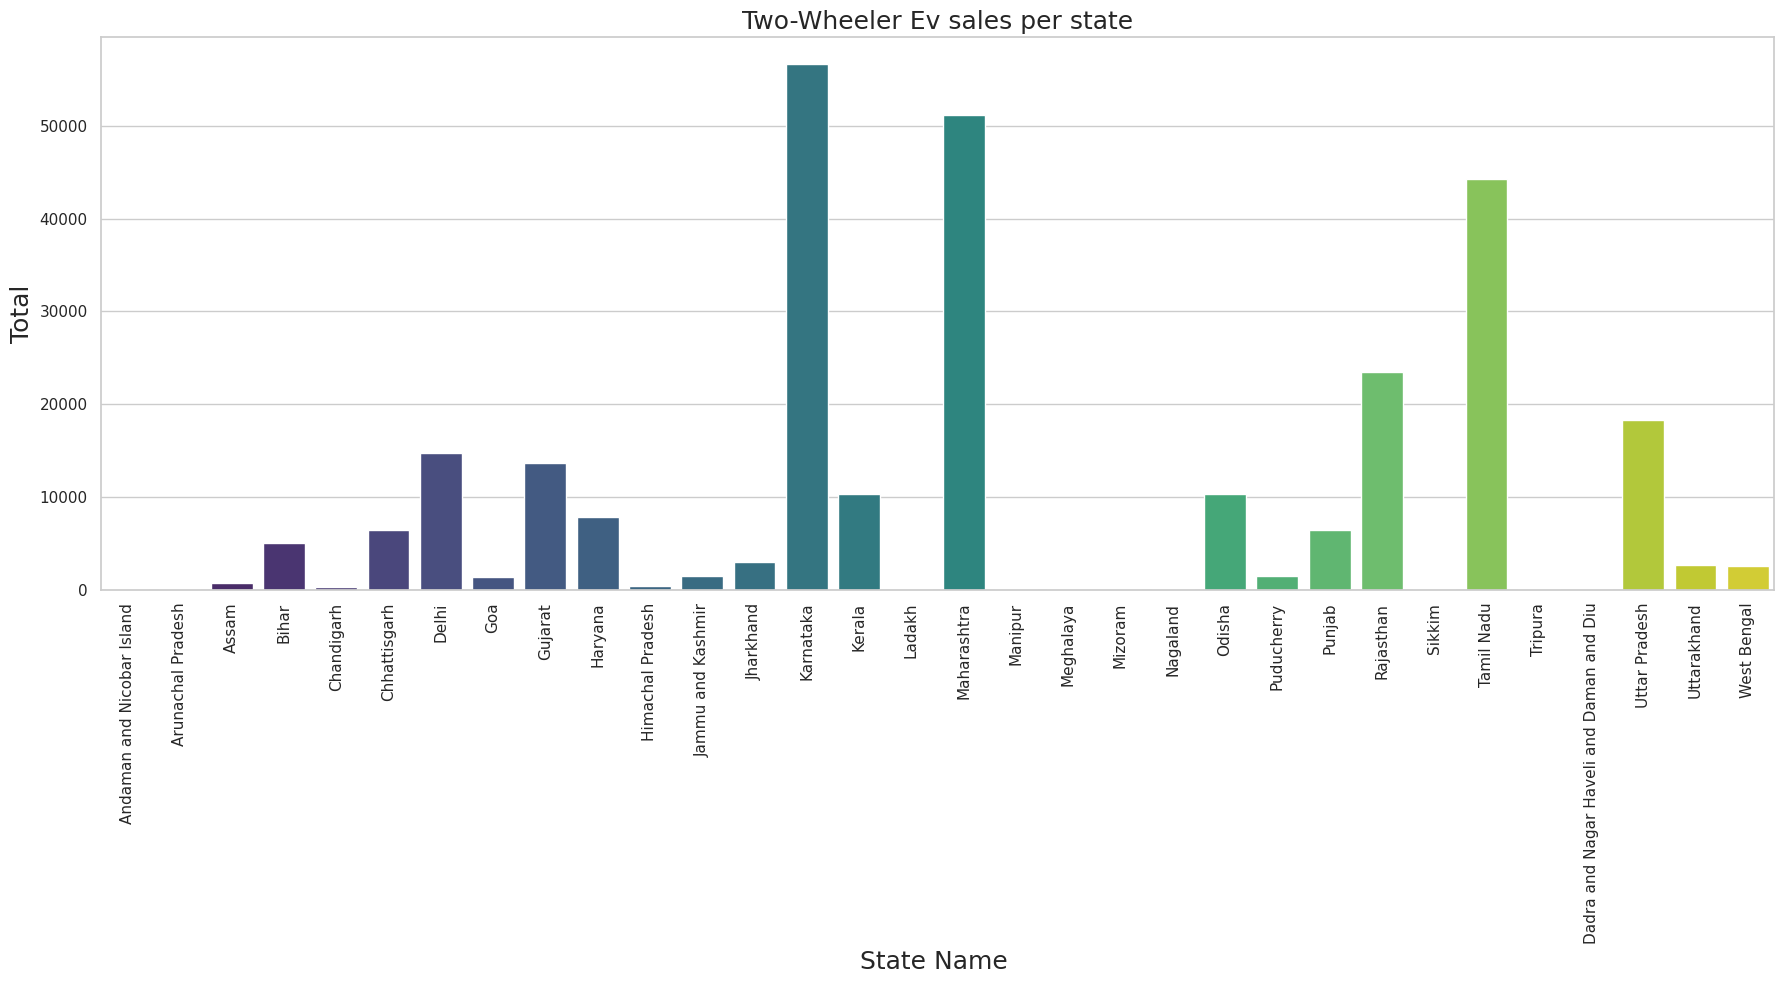

In [58]:
# for two wheeler

plt.figure(figsize=(18,10),facecolor='White')
sns.barplot(data=df,x='State_Name',y='Two_Wheeler',palette='viridis')
plt.xticks(rotation=90)
plt.title("Two-Wheeler Ev sales per state", fontsize=18)
plt.xlabel("State Name ",fontsize=18)
plt.ylabel("Total",fontsize=18)
plt.tight_layout()
plt.show()

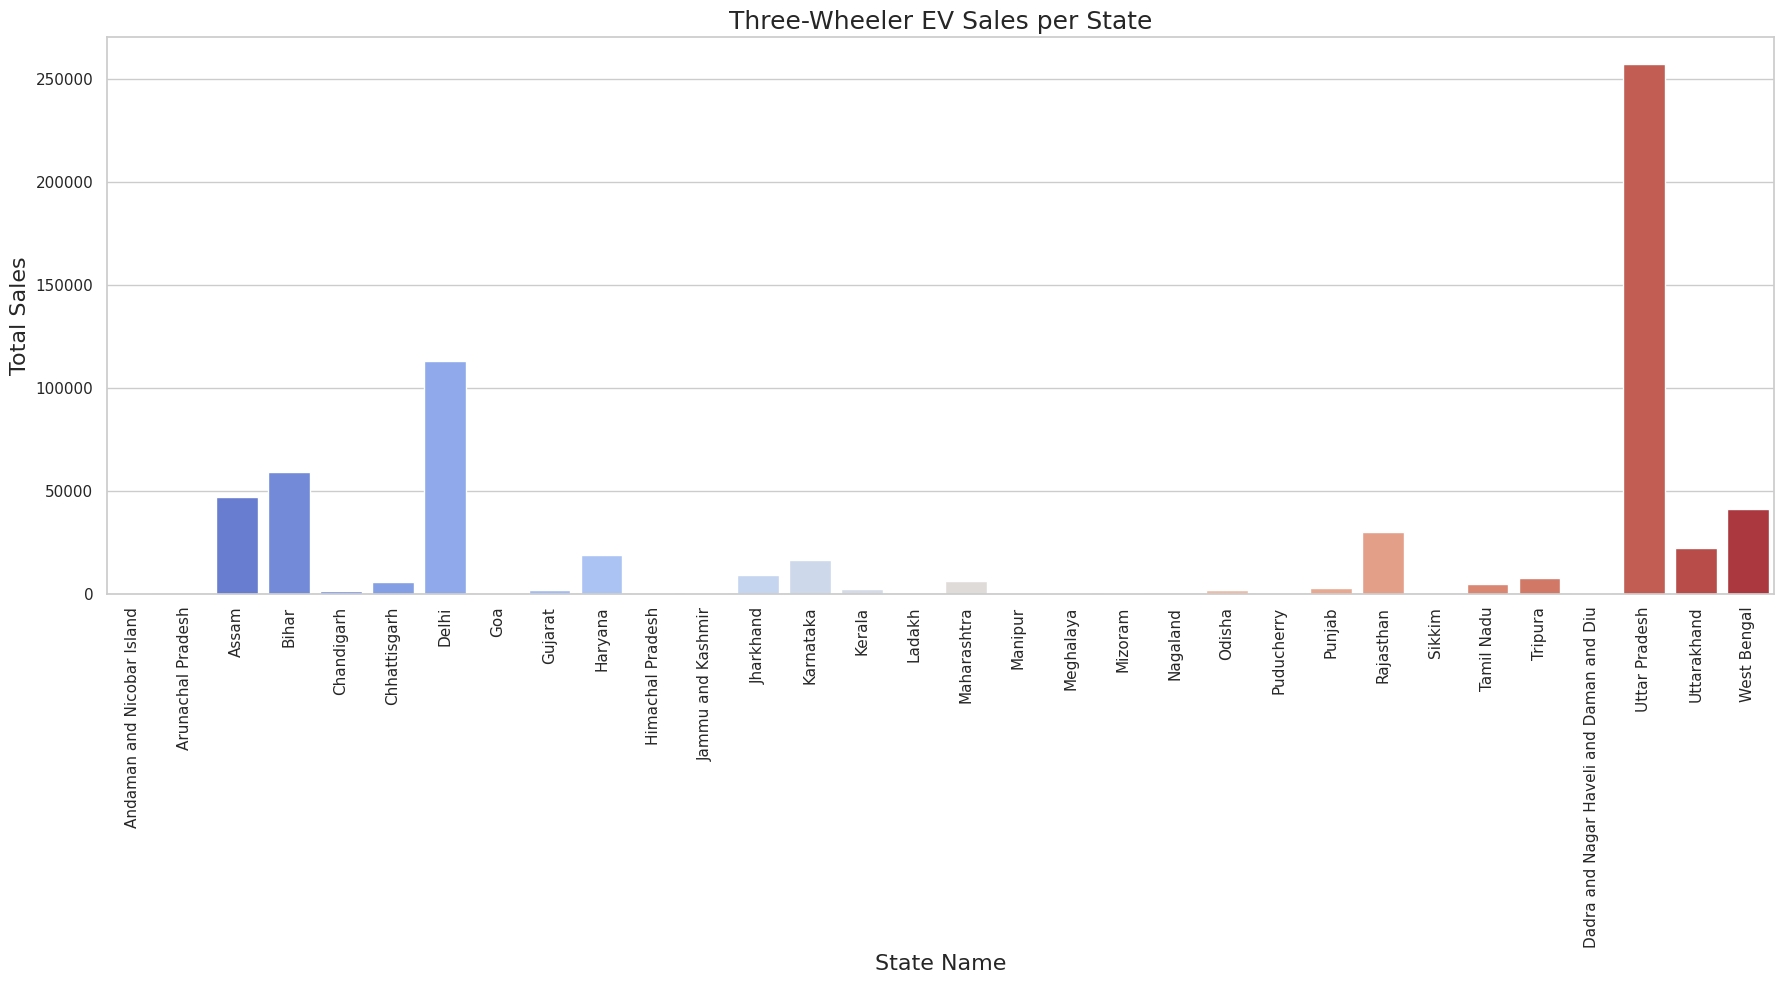

In [57]:
#for Three Wheeler

plt.figure(figsize=(18, 10), facecolor='White')
sns.barplot(data=df, x='State_Name', y='Three_Wheeler', palette='coolwarm')
plt.xticks(rotation=90)  # Rotate state names for better readability
plt.title("Three-Wheeler EV Sales per State", fontsize=18)
plt.xlabel("State Name", fontsize=16)
plt.ylabel("Total Sales", fontsize=16)
plt.tight_layout()
plt.show()


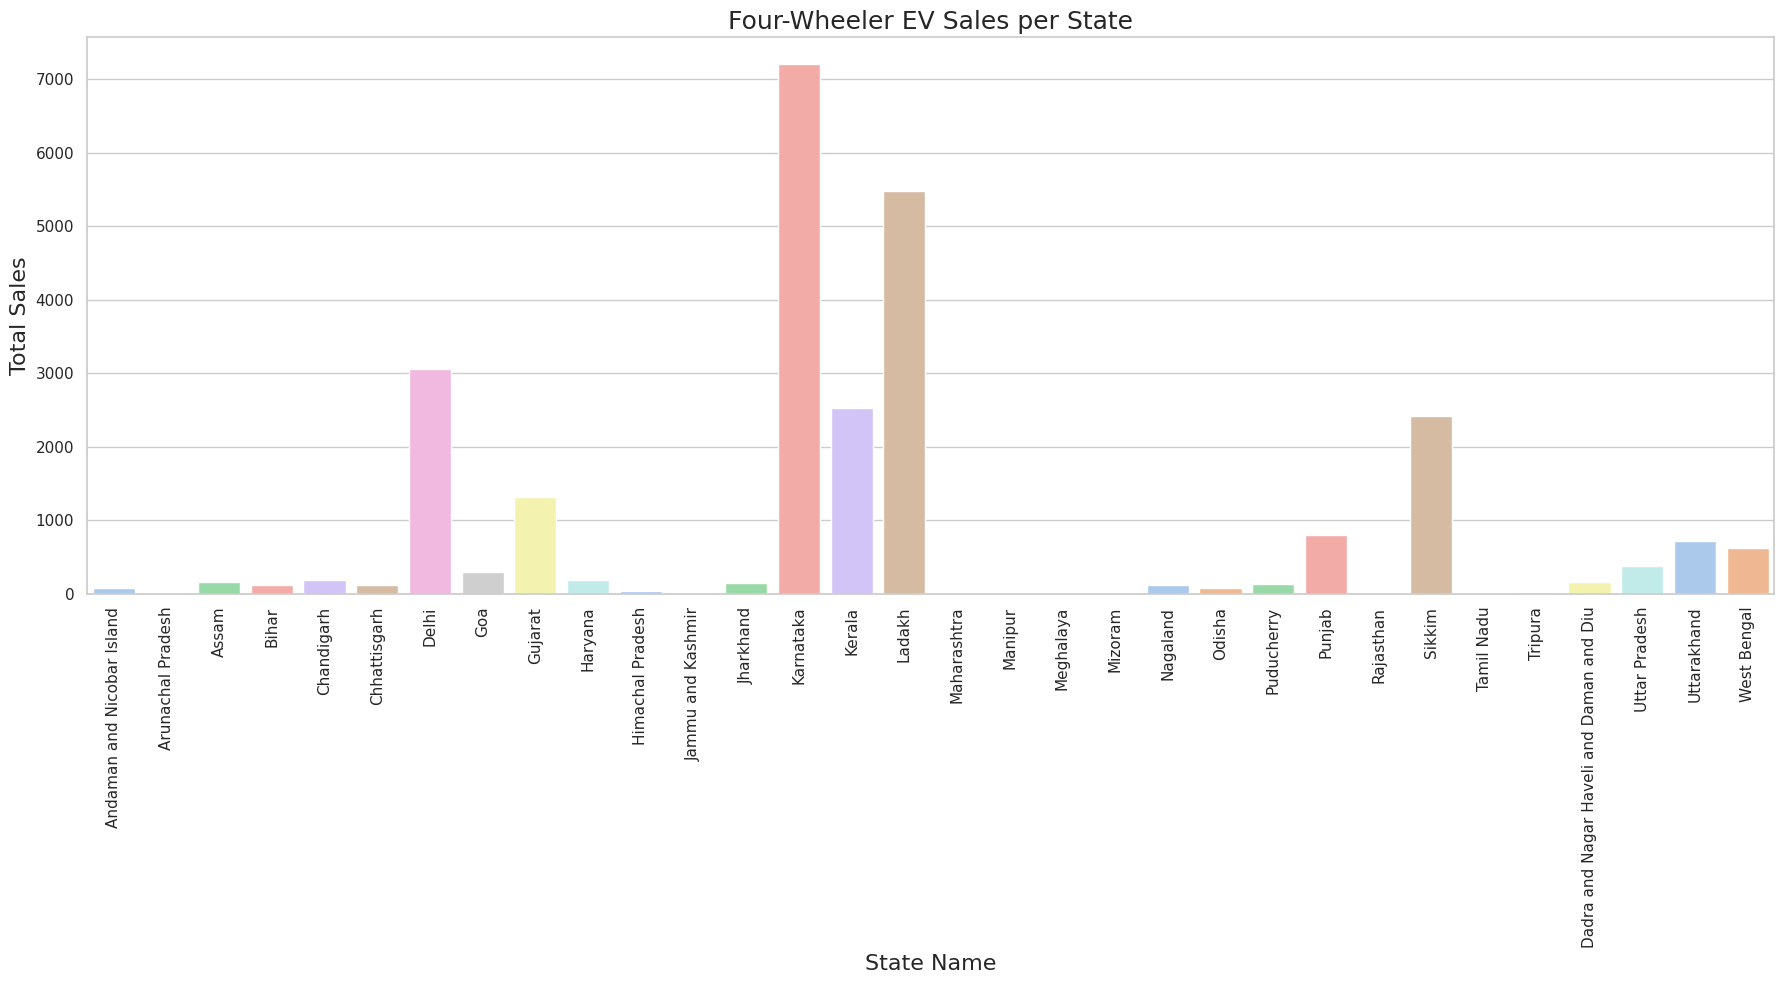

In [56]:
#for four wheeler

plt.figure(figsize=(18, 10), facecolor='White')
sns.barplot(data=df, x='State_Name', y='Four_Wheeler', palette='pastel')
plt.xticks(rotation=90)  # Rotate state names for better readability
plt.title("Four-Wheeler EV Sales per State", fontsize=18)
plt.xlabel("State Name", fontsize=16)
plt.ylabel("Total Sales", fontsize=16)
plt.tight_layout()
plt.show()


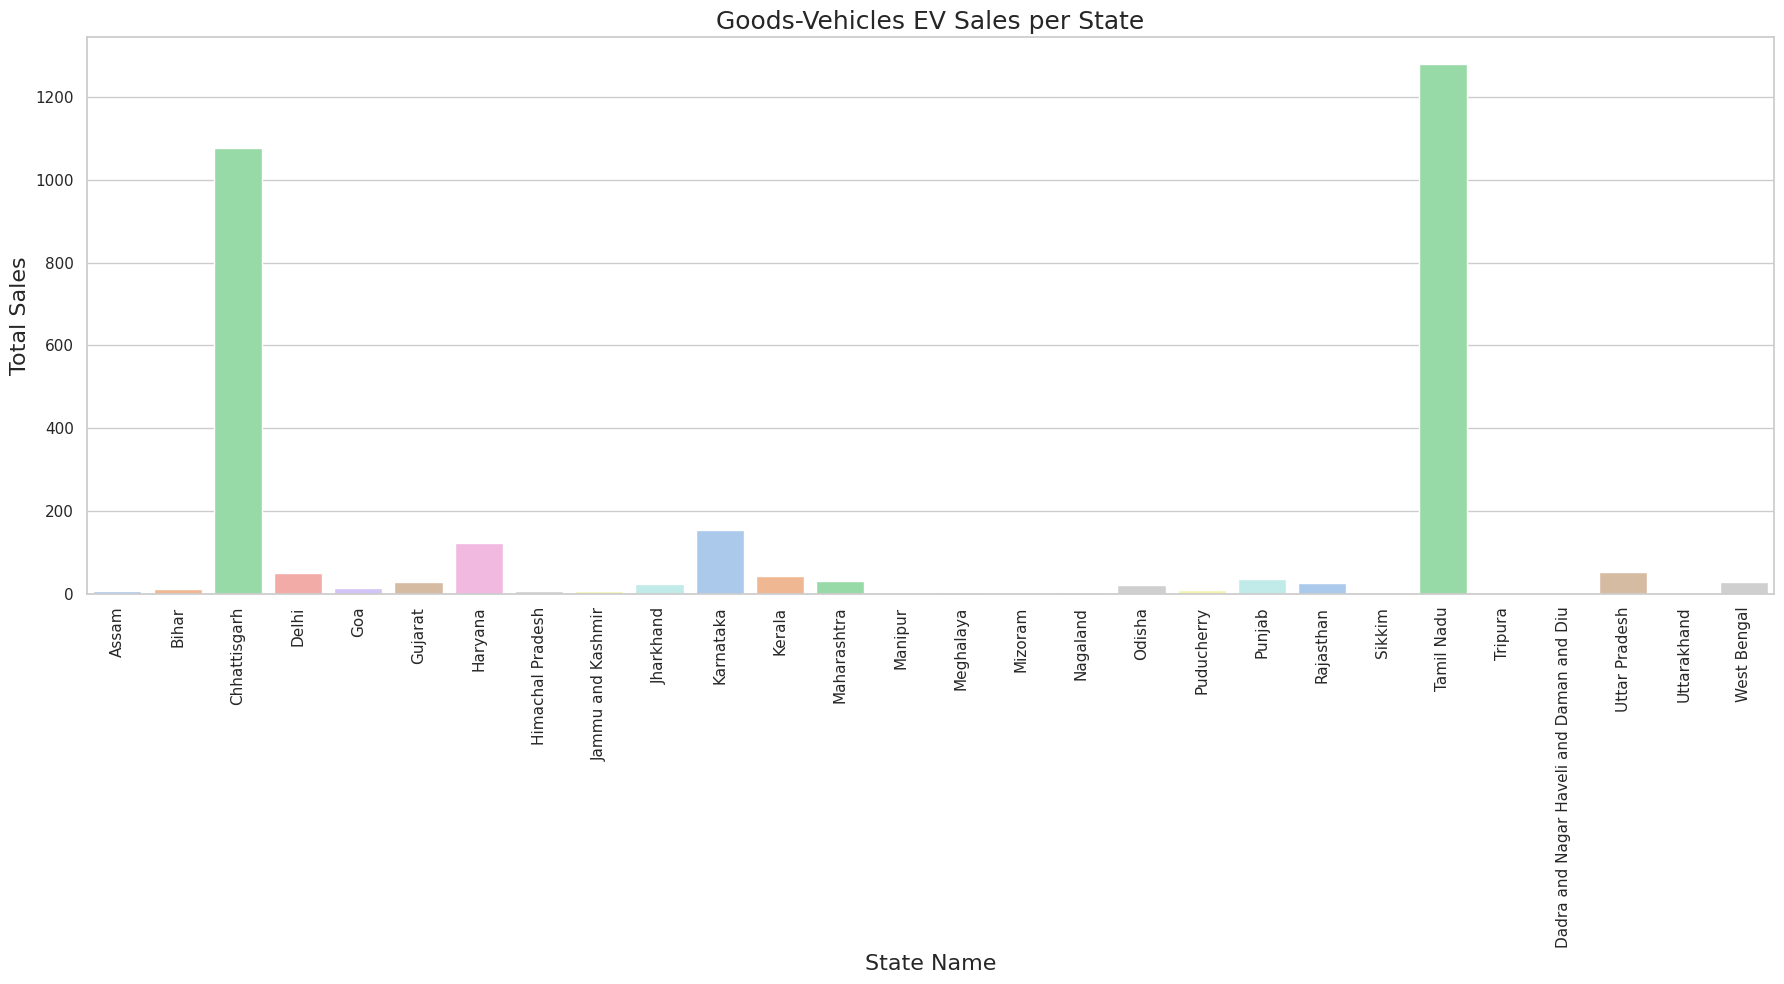

In [64]:
#for Good-Vechicles

df = df[df['State_Name'].notnull()]  # Drop rows with missing state names
df['Goods_Vehicles'] = pd.to_numeric(df['Goods_Vehicles'], errors='coerce')  # Convert to numeric
df = df[df['Goods_Vehicles'].notnull()]  # Drop rows with invalid Goods_Vehicles values

# Plot
plt.figure(figsize=(18, 10), facecolor='White')
sns.barplot(data=df, x='State_Name', y='Goods_Vehicles', palette='pastel')
plt.xticks(rotation=90)  # Rotate state names for better readability
plt.title("Goods-Vehicles EV Sales per State", fontsize=18)
plt.xlabel("State Name", fontsize=16)
plt.ylabel("Total Sales", fontsize=16)
plt.tight_layout()
plt.show()


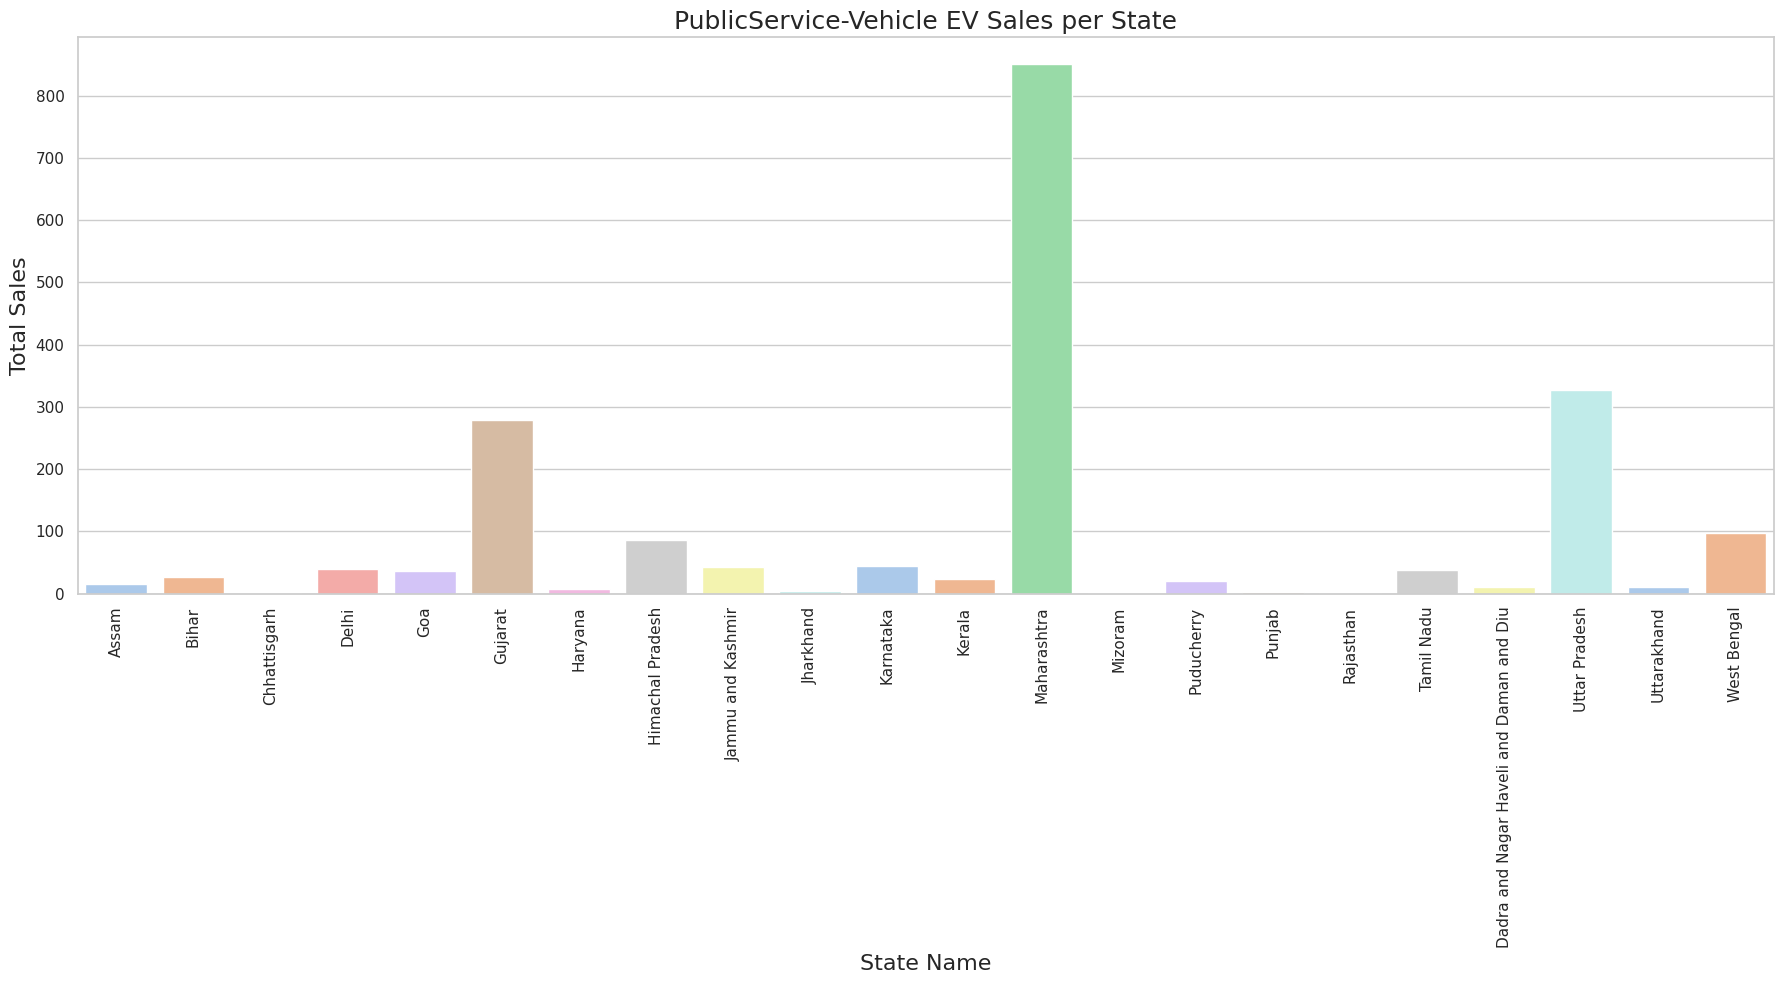

In [66]:
#for Public service-Vechicle

df = df[df['State_Name'].notnull()]  # Drop rows with missing state names
df['Public_Service_Vehicle'] = pd.to_numeric(df['Public_Service_Vehicle'], errors='coerce')  # Convert to numeric
df = df[df['Public_Service_Vehicle'].notnull()]  # Drop rows with invalid Goods_Vehicles values

# Plot
plt.figure(figsize=(18, 10), facecolor='White')
sns.barplot(data=df, x='State_Name', y='Public_Service_Vehicle', palette='pastel')
plt.xticks(rotation=90)  # Rotate state names for better readability
plt.title("PublicService-Vehicle EV Sales per State", fontsize=18)
plt.xlabel("State Name", fontsize=16)
plt.ylabel("Total Sales", fontsize=16)
plt.tight_layout()
plt.show()



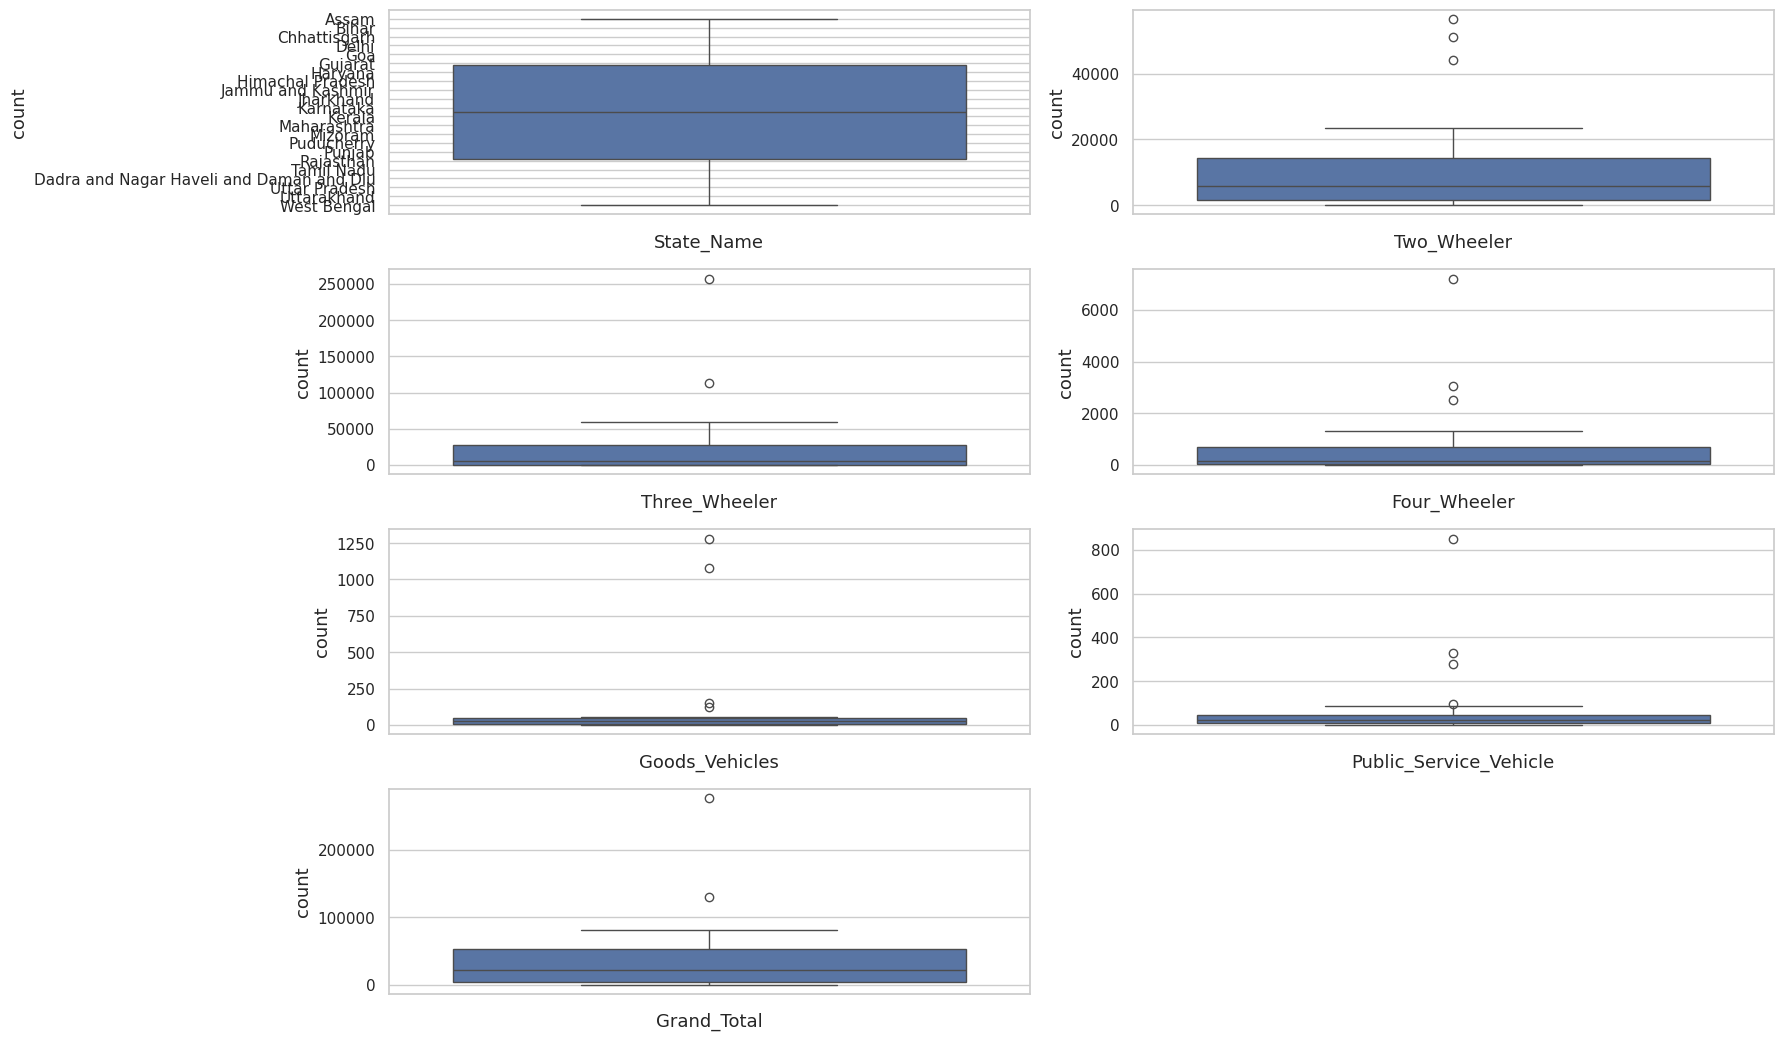

In [68]:
#checking outliers

# checking for outliers as k means is highely impacted by outliers

plt.figure(figsize=(18,18),facecolor='white')
columnnum=1

for column in df:
    if columnnum<=13:
        ax=plt.subplot(7,2,columnnum)
        sns.boxplot(df[column])
        plt.xlabel(column,fontsize=13)
        plt.ylabel('count',fontsize=13)
    columnnum+=1
plt.tight_layout()

**Scaling**

In [69]:
#Separating numeric and non-numeric data
numeric_cols = df.select_dtypes(include='number').columns
non_numeric_cols = df.select_dtypes(exclude='number').columns

#Scaling numeric columns only
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

**Model Creation(Segementation using K means)**

In [70]:
#numeric data for PCA and Clustering

x= df_scaled.select_dtypes(include='number')



In [71]:
# plotting a graph to find elbow point to get optimal no of clusters


inertia=[]
K_range = range(1, 11)

for k in K_range:
    kmeans=KMeans(n_clusters=k, random_state=52)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

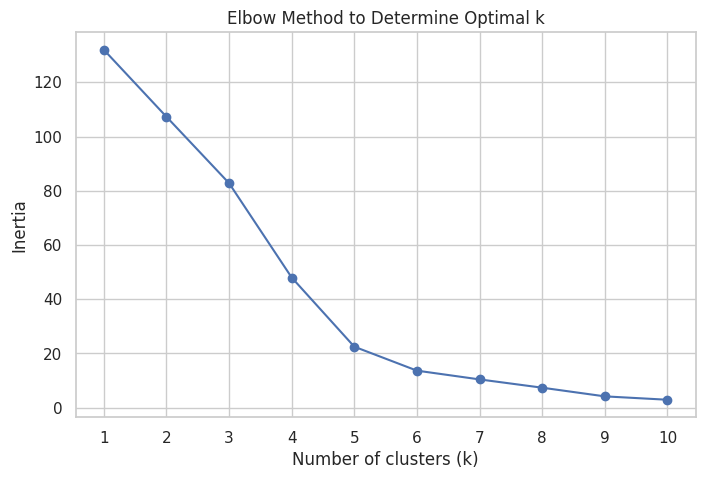

In [72]:
# plotting graph to vizualize the elbow curve

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(K_range)
plt.show()

We can see the sharp decrease at 5 and it is getting flat hence the optimal no of clusters should be 5



In [73]:
# Fitting  KMeans on original data
kmeans = KMeans(n_clusters=5, random_state=52)
y_kmeans = kmeans.fit_predict(x)


In [74]:
# Fitting PCA on original data (12D to 2D)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

In [75]:
#Transforming the cluster centroids into the same PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

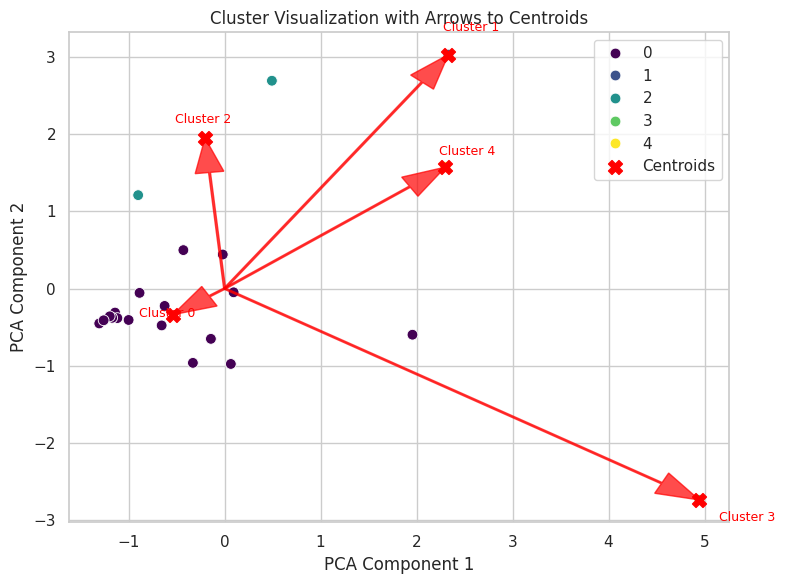

In [76]:
# Plotting the scatterplot for the veriables
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=y_kmeans, palette='viridis', s=60)


# Plot cluster centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', s=100, marker='X', label='Centroids')


# Add arrows from origin to each centroid
for i, (cx, cy) in enumerate(centroids_pca):
    plt.arrow(0, 0, cx, cy, color='red', alpha=0.7, width=0.02,
              head_width=0.3, length_includes_head=True)
    plt.text(cx * 1.1, cy * 1.1, f'Cluster {i}', color='red', fontsize=9, ha='center')

plt.title('Cluster Visualization with Arrows to Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()